<a href="https://colab.research.google.com/github/vimesh630/ML_CW/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries and Mount Google Drive

In [1]:
# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Preprocessed Data

In [2]:
# Load preprocessed data
train_data_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/train_data.csv'
test_data_path = '/content/drive/My Drive/ML Coursework/Preprocessed Dataset/test_data.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Split features (X) and target (y)
X_train = train_data.drop('y', axis=1).values
y_train = train_data['y'].values
X_test = test_data.drop('y', axis=1).values
y_test = test_data['y'].values

Define and Train the Random Forest Model

In [3]:
# Define and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)  # Use 100 decision trees
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Make Predictions on the Random Forest

In [4]:
# Predict on test data
y_pred = rf_model.predict(X_test)

Evaluate the Model

In [5]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.9627

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      8015
           1       0.95      0.98      0.96      8072

    accuracy                           0.96     16087
   macro avg       0.96      0.96      0.96     16087
weighted avg       0.96      0.96      0.96     16087



Visualize the Confusion Matrix

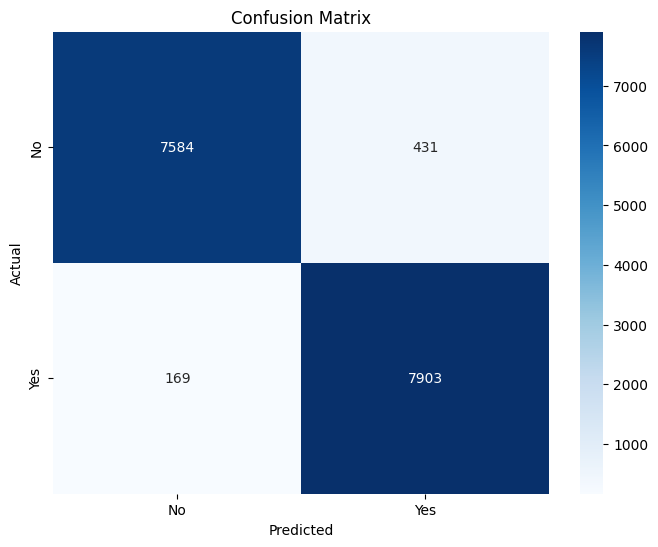

In [6]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Visualize Feature Importance

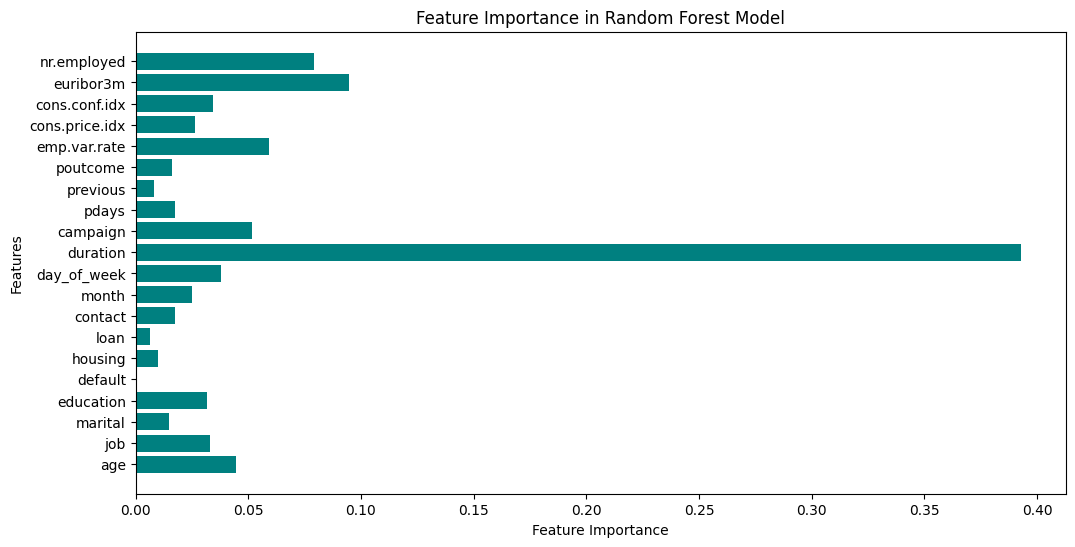

In [7]:
# Feature Importance
feature_importances = rf_model.feature_importances_
feature_names = train_data.drop('y', axis=1).columns
plt.figure(figsize=(12, 6))
plt.barh(feature_names, feature_importances, color='teal')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.show()

Example: Predict the first 10 clients in the test set

In [8]:
# Select the first 10 clients from the test dataset
sample_clients = X_test[:10]

# Predict probabilities and classes for these clients
predicted_probabilities = rf_model.predict_proba(sample_clients)[:, 1]  # Probabilities for class "1" (Yes)
predicted_classes = rf_model.predict(sample_clients)  # Binary predictions

# Print the results
print("Predicted Probabilities for 'Yes':\n", predicted_probabilities)
print("Predicted Classes (0 = No, 1 = Yes):\n", predicted_classes)

Predicted Probabilities for 'Yes':
 [0.   0.11 0.99 0.98 0.   0.89 0.79 0.99 0.   0.06]
Predicted Classes (0 = No, 1 = Yes):
 [0 0 1 1 0 1 1 1 0 0]
